In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Creating Dataframes by Loading CSV Files

In [22]:
df_0_shot = pd.read_csv('../results/mbpp_correct/mbpp_0_shot.csv')
df_3_shot = pd.read_csv('../results/mbpp_correct/mbpp_3_shot.csv')

In [ ]:
df_0_shot.info()

In [ ]:
df_3_shot.info()

### Cast data types

In [23]:
# Converting 'LLM' and 'Benchmark prompt' to string
df_0_shot['LLM'] = df_0_shot['LLM'].astype(str)
df_0_shot['Benchmark prompt'] = df_0_shot['Benchmark prompt'].astype(str)

df_3_shot['LLM'] = df_0_shot['LLM'].astype(str)
df_3_shot['Benchmark prompt'] = df_0_shot['Benchmark prompt'].astype(str)

### Remove outliers

In [24]:
import pandas as pd

THRESHOLD = 0.5
# Função para remover outliers usando o método do IQR
def remove_outliers(group, threshold=THRESHOLD):
    # Calcular IQR
    Q1 = group['CPU Energy (J)'].quantile(0.25)
    Q3 = group['CPU Energy (J)'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calcular limites para outliers
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    # Filtrar os dados para remover outliers
    filtered_group = group[(group['CPU Energy (J)'] >= lower_bound) & (group['CPU Energy (J)'] <= upper_bound)]
    
    # Calcular o número de outliers removidos
    num_removed = len(group) - len(filtered_group)
    
    return filtered_group, num_removed

# Inicializando listas para armazenar o número de outliers removidos
outliers_list_0 = []
outliers_list_3 = []

# Remover outliers para df_0_shot
df_0_no_outliers_list = []
for (llm, prompt), group in df_0_shot.groupby(['LLM', 'Benchmark prompt']):
    filtered_group, num_removed = remove_outliers(group, threshold=THRESHOLD)  # Ajuste do fator
    df_0_no_outliers_list.append(filtered_group)
    outliers_list_0.append([llm, prompt, num_removed])  # Armazenar contagem de outliers removidos

df_0_no_outliers = pd.concat(df_0_no_outliers_list).reset_index(drop=True)

# Remover outliers para df_3_shot
df_3_no_outliers_list = []
for (llm, prompt), group in df_3_shot.groupby(['LLM', 'Benchmark prompt']):
    filtered_group, num_removed = remove_outliers(group, threshold=THRESHOLD)  # Ajuste do fator
    df_3_no_outliers_list.append(filtered_group)
    outliers_list_3.append([llm, prompt, num_removed])  # Armazenar contagem de outliers removidos

df_3_no_outliers = pd.concat(df_3_no_outliers_list).reset_index(drop=True)

# Exibir o número de outliers removidos
print("Outliers removidos de 0-shot:", outliers_list_0)
print("Outliers removidos de 3-shot:", outliers_list_3)


Outliers removidos de 0-shot: [['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/100', 0], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/101', 2], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/102', 0], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/103', 0], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/104', 1], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/105', 2], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/106', 0], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/108', 0], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/109', 0], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/11', 0], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/111', 1], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/113', 0], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/116', 4], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/118', 0], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/119', 0], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/12', 0], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/120', 1], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/123', 1], ['Meta-Llama-3-8B-Instruct-Q6_K', 'Mbpp/124', 3], ['Meta-Llama-3-8B-Ins

### Statistical tests

In [25]:
df_0_no_outliers['Origin'] = '0-shot'
df_3_no_outliers['Origin'] = '3-shot'

df_combined_no_outliers = pd.concat([df_0_no_outliers, df_3_no_outliers], ignore_index=True)
df_combined_no_outliers.columns


Index(['LLM', 'Benchmark prompt', 'Execution time (s)', 'CPU Energy (J)',
       'RAM Energy (J)', 'GPU Energy (J)', 'CPU Power (W)', 'RAM Power (W)',
       'GPU Power (W)', 'CO2 emissions (Kg)', 'CO2 emissions rate (Kg/s)',
       'MBPP (unsanitized) pass@1', 'MBPP+ (unsanitized) pass@1',
       'MBPP (sanitized) pass@1', 'MBPP+ (sanitized) pass@1',
       'MBPP (unsanitized) pass@10', 'MBPP+ (unsanitized) pass@10',
       'MBPP (sanitized) pass@10', 'MBPP+ (sanitized) pass@10',
       'GoogleBLEU (unsanitized)', 'CodeBLEU (unsanitized)',
       'SacreBLEU (unsanitized)', 'GoogleBLEU (sanitized)',
       'CodeBLEU (sanitized)', 'SacreBLEU (sanitized)', 'Origin'],
      dtype='object')

#### By benchmark prompt

In [26]:
import pandas as pd
from scipy.stats import shapiro

# Inicializar listas para armazenar os resultados
results = []

# Iterar sobre os grupos de df_combined_no_outliers
for (llm, prompt, prompt_type), group in df_combined_no_outliers.groupby(['LLM', 'Benchmark prompt', 'Origin']):
    # Teste de Shapiro-Wilk para CPU Energy
    stat_cpu_energy, p_value_cpu_energy = shapiro(group['CPU Energy (J)'])  
    is_normal_cpu_energy = 'Normal' if p_value_cpu_energy > 0.05 else 'Not Normal'
    results.append([llm, prompt, 'CPU Energy (J)', stat_cpu_energy, p_value_cpu_energy, is_normal_cpu_energy, prompt_type])
    
    # Teste de Shapiro-Wilk para Execution Time
    stat_execution_time, p_value_execution_time = shapiro(group['Execution time (s)'])  
    is_normal_execution_time = 'Normal' if p_value_execution_time > 0.05 else 'Not Normal'
    results.append([llm, prompt, 'Execution Time (s)', stat_execution_time, p_value_execution_time, is_normal_execution_time, prompt_type])

# Criar um DataFrame com os resultados
shapiro_results = pd.DataFrame(results, columns=[
    'LLM', 'Benchmark prompt', 'Metric', 'Statistic', 'p-value', 'Normality', 'Prompt Type'])

# Exibir os resultados
shapiro_results


,LLM,Benchmark prompt,Metric,Statistic,p-value,Normality,Prompt Type
0,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/100,CPU Energy (J),0.840893,0.045224,Not Normal,0-shot
1,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/100,Execution Time (s),0.840161,0.044320,Not Normal,0-shot
2,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/100,CPU Energy (J),0.714685,0.005351,Not Normal,3-shot
3,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/100,Execution Time (s),0.616311,0.000422,Not Normal,3-shot
4,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/101,CPU Energy (J),0.887068,0.219724,Normal,0-shot
...,...,...,...,...,...,...,...
7555,starling-lm-7b-alpha.Q5_K_S,Mbpp/98,Execution Time (s),0.666821,0.000944,Not Normal,3-shot
7556,starling-lm-7b-alpha.Q5_K_S,Mbpp/99,CPU Energy (J),0.930869,0.489666,Normal,0-shot
7557,starling-lm-7b-alpha.Q5_K_S,Mbpp/99,Execution Time (s),0.921787,0.407243,Normal,0-shot
7558,starling-lm-7b-alpha.Q5_K_S,Mbpp/99,CPU Energy (J),0.946533,0.676266,Normal,3-shot


In [27]:
shapiro_results.groupby(['LLM', "Metric",'Prompt Type', 'Normality']).size().unstack(fill_value=0)

Normality                                                           Normal  \
LLM                                 Metric             Prompt Type           
Meta-Llama-3-8B-Instruct-Q6_K       CPU Energy (J)     0-shot          202   
                                                       3-shot          160   
                                    Execution Time (s) 0-shot          204   
                                                       3-shot          123   
codegeex4-all-9b-Q6_K_L             CPU Energy (J)     0-shot          206   
                                                       3-shot          272   
                                    Execution Time (s) 0-shot          208   
                                                       3-shot          265   
codellama-7b-instruct.Q5_K_M        CPU Energy (J)     0-shot          272   
                                                       3-shot          287   
                                    Execution Time (s) 0-shot          267   
                                                       3-shot          278   
deepseek-coder-6.7b-instruct.Q5_K_M CPU Energy (J)     0-shot          203   
                                                       3-shot          277   
                                    Execution Time (s) 0-shot          199   
                                                       3-shot          266   
starling-lm-7b-alpha.Q5_K_S         CPU Energy (J)     0-shot          231   
                                                       3-shot          174   
                                    Execution Time (s) 0-shot          215   
                                                       3-shot          131   

Normality                                                           Not Normal  
LLM                                 Metric             Prompt Type              
Meta-Llama-3-8B-Instruct-Q6_K       CPU Energy (J)     0-shot              176  
                                                       3-shot              218  
                                    Execution Time (s) 0-shot              174  
                                                       3-shot              255  
codegeex4-all-9b-Q6_K_L             CPU Energy (J)     0-shot              172  
                                                       3-shot              106  
                                    Execution Time (s) 0-shot              170  
                                                       3-shot              113  
codellama-7b-instruct.Q5_K_M        CPU Energy (J)     0-shot              106  
                                                       3-shot               91  
                                    Execution Time (s) 0-shot              111  
                                                       3-shot              100  
deepseek-coder-6.7b-instruct.Q5_K_M CPU Energy (J)     0-shot              175  
                                                       3-shot              101  
                                    Execution Time (s) 0-shot              179  
                                                       3-shot              112  
starling-lm-7b-alpha.Q5_K_S         CPU Energy (J)     0-shot              147  
                                                       3-shot              204  
                                    Execution Time (s) 0-shot              163  
                                                       3-shot              247

In [28]:
import pandas as pd
from scipy.stats import shapiro, ttest_ind, wilcoxon

# Inicializar listas para armazenar os resultados
t_test_results = []

# Definir o nível de significância
alpha = 0.05

# Iterar sobre os grupos de df_combined_no_outliers
for (llm, prompt), group in df_combined_no_outliers.groupby(['LLM', 'Benchmark prompt']):
    
    # Separar as amostras de 0-shot e 3-shot para CPU Energy
    group_0_energy = group[group['Origin'] == '0-shot']['CPU Energy (J)']
    group_3_energy = group[group['Origin'] == '3-shot']['CPU Energy (J)']
    
    # Separar as amostras de 0-shot e 3-shot para Execution Time
    group_0_time = group[group['Origin'] == '0-shot']['Execution time (s)']
    group_3_time = group[group['Origin'] == '3-shot']['Execution time (s)']
    
    # Verificar se ambas as amostras têm pelo menos 3 elementos para CPU Energy
    if len(group_0_energy) < 3 or len(group_3_energy) < 3:
        continue  # Pular se qualquer grupo tiver menos de 3 amostras

    # Teste de normalidade para CPU Energy
    stat_0_energy, p_value_0_energy = shapiro(group_0_energy)
    is_normal_0_energy = p_value_0_energy > 0.05

    stat_3_energy, p_value_3_energy = shapiro(group_3_energy)
    is_normal_3_energy = p_value_3_energy > 0.05

    # Aplicar os testes apropriados para CPU Energy
    if is_normal_0_energy and is_normal_3_energy:
        # Ambos são normais, usar t-test
        stat_energy, p_value_energy = ttest_ind(group_0_energy, group_3_energy)
        test_type_energy = 't-test'
    else:
        # Pelo menos um não é normal, usar Wilcoxon
        if len(group_0_energy) == len(group_3_energy):
            stat_energy, p_value_energy = wilcoxon(group_0_energy, group_3_energy)
            test_type_energy = 'Wilcoxon'
        else:
            continue

    # Verificar se é estatisticamente significativo para CPU Energy
    is_significant_energy = 'Significant' if p_value_energy < alpha else 'Not Significant'
    
    # Armazenar os resultados para CPU Energy
    t_test_results.append([llm, prompt, 'CPU Energy (J)', test_type_energy, stat_energy, p_value_energy, is_significant_energy])

    # Verificar se ambas as amostras têm pelo menos 3 elementos para Execution Time
    if len(group_0_time) < 3 or len(group_3_time) < 3:
        continue  # Pular se qualquer grupo tiver menos de 3 amostras

    # Teste de normalidade para Execution Time
    stat_0_time, p_value_0_time = shapiro(group_0_time)
    is_normal_0_time = p_value_0_time > 0.05

    stat_3_time, p_value_3_time = shapiro(group_3_time)
    is_normal_3_time = p_value_3_time > 0.05

    # Aplicar os testes apropriados para Execution Time
    if is_normal_0_time and is_normal_3_time:
        # Ambos são normais, usar t-test
        stat_time, p_value_time = ttest_ind(group_0_time, group_3_time)
        test_type_time = 't-test'
    else:
        # Pelo menos um não é normal, usar Wilcoxon
        if len(group_0_time) == len(group_3_time):
            stat_time, p_value_time = wilcoxon(group_0_time, group_3_time)
            test_type_time = 'Wilcoxon'
        else:
            continue

    # Verificar se é estatisticamente significativo para Execution Time
    is_significant_time = 'Significant' if p_value_time < alpha else 'Not Significant'

    # Armazenar os resultados para Execution Time
    t_test_results.append([llm, prompt, 'Execution Time (s)', test_type_time, stat_time, p_value_time, is_significant_time])

# Criar um DataFrame com os resultados
test_results_df = pd.DataFrame(t_test_results, columns=[
    'LLM', 'Benchmark prompt', 'Metric', 'Test Type', 'Statistic', 'p-value', 'Significance'])

# Exibir os resultados
test_results_df


,LLM,Benchmark prompt,Metric,Test Type,Statistic,p-value,Significance
0,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/103,CPU Energy (J),t-test,6.556342,9.097002e-06,Significant
1,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/103,Execution Time (s),t-test,6.515288,9.767620e-06,Significant
2,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/105,CPU Energy (J),t-test,7.780700,4.991769e-06,Significant
3,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/105,Execution Time (s),t-test,7.686024,5.651182e-06,Significant
4,Meta-Llama-3-8B-Instruct-Q6_K,Mbpp/109,CPU Energy (J),t-test,4.716236,2.757525e-04,Significant
...,...,...,...,...,...,...,...
1768,starling-lm-7b-alpha.Q5_K_S,Mbpp/94,CPU Energy (J),t-test,117.727788,4.501525e-21,Significant
1769,starling-lm-7b-alpha.Q5_K_S,Mbpp/94,Execution Time (s),t-test,128.053188,1.510405e-21,Significant
1770,starling-lm-7b-alpha.Q5_K_S,Mbpp/96,CPU Energy (J),t-test,364.682149,2.998614e-29,Significant
1771,starling-lm-7b-alpha.Q5_K_S,Mbpp/99,CPU Energy (J),t-test,87.467667,9.854353e-22,Significant


In [29]:
# Inicializar uma lista para armazenar os resultados
llm_metric_significance_results = []

# Iterar sobre cada LLM e contar as combinações de 'Metric' e 'Significance'
for llm, group in test_results_df.groupby('LLM'):
    # Contar as ocorrências de combinações entre 'Metric' e 'Significance' para o LLM atual
    llm_counts = group[['Metric', 'Significance']].value_counts().reset_index(name='Counts')
    llm_counts['LLM'] = llm  # Adicionar a coluna do LLM correspondente
    
    # Adicionar os resultados para este LLM à lista
    llm_metric_significance_results.append(llm_counts)

# Concatenar todos os DataFrames em um único DataFrame
llm_metric_significance_df = pd.concat(llm_metric_significance_results, ignore_index=True)

# Exibir o DataFrame final
llm_metric_significance_df


,Metric,Significance,Counts,LLM
0,CPU Energy (J),Significant,132,Meta-Llama-3-8B-Instruct-Q6_K
1,Execution Time (s),Significant,115,Meta-Llama-3-8B-Instruct-Q6_K
2,CPU Energy (J),Not Significant,2,Meta-Llama-3-8B-Instruct-Q6_K
3,Execution Time (s),Not Significant,1,Meta-Llama-3-8B-Instruct-Q6_K
4,CPU Energy (J),Significant,130,codegeex4-all-9b-Q6_K_L
5,Execution Time (s),Significant,125,codegeex4-all-9b-Q6_K_L
6,CPU Energy (J),Not Significant,60,codegeex4-all-9b-Q6_K_L
7,Execution Time (s),Not Significant,51,codegeex4-all-9b-Q6_K_L
8,CPU Energy (J),Significant,156,codellama-7b-instruct.Q5_K_M
9,Execution Time (s),Significant,148,codellama-7b-instruct.Q5_K_M


#### By LLM

In [30]:
import pandas as pd
from scipy.stats import shapiro

# Inicializar listas para armazenar os resultados
results = []

# Iterar sobre os grupos de df_combined_no_outliers
for (llm, prompt_type), group in df_combined_no_outliers.groupby(['LLM', 'Origin']):
    # Teste de Shapiro-Wilk para CPU Energy
    stat_cpu_energy, p_value_cpu_energy = shapiro(group['CPU Energy (J)'])  
    is_normal_cpu_energy = 'Normal' if p_value_cpu_energy > 0.05 else 'Not Normal'
    results.append([llm, 'CPU Energy (J)', stat_cpu_energy, p_value_cpu_energy, is_normal_cpu_energy, prompt_type])
    
    # Teste de Shapiro-Wilk para Execution Time
    stat_execution_time, p_value_execution_time = shapiro(group['Execution time (s)'])  
    is_normal_execution_time = 'Normal' if p_value_execution_time > 0.05 else 'Not Normal'
    results.append([llm, 'Execution Time (s)', stat_execution_time, p_value_execution_time, is_normal_execution_time, prompt_type])

# Criar um DataFrame com os resultados
shapiro_results = pd.DataFrame(results, columns=[
    'LLM', 'Metric', 'Statistic', 'p-value', 'Normality', 'Prompt Type'])

# Exibir os resultados
shapiro_results

,LLM,Metric,Statistic,p-value,Normality,Prompt Type
0,Meta-Llama-3-8B-Instruct-Q6_K,CPU Energy (J),0.902154,7.415671e-42,Not Normal,0-shot
1,Meta-Llama-3-8B-Instruct-Q6_K,Execution Time (s),0.900313,3.845163e-42,Not Normal,0-shot
2,Meta-Llama-3-8B-Instruct-Q6_K,CPU Energy (J),0.740074,0.000000e+00,Not Normal,3-shot
3,Meta-Llama-3-8B-Instruct-Q6_K,Execution Time (s),0.738220,0.000000e+00,Not Normal,3-shot
4,codegeex4-all-9b-Q6_K_L,CPU Energy (J),0.738540,0.000000e+00,Not Normal,0-shot
5,codegeex4-all-9b-Q6_K_L,Execution Time (s),0.738035,0.000000e+00,Not Normal,0-shot
6,codegeex4-all-9b-Q6_K_L,CPU Energy (J),0.771483,0.000000e+00,Not Normal,3-shot
7,codegeex4-all-9b-Q6_K_L,Execution Time (s),0.769932,0.000000e+00,Not Normal,3-shot
8,codellama-7b-instruct.Q5_K_M,CPU Energy (J),0.539419,0.000000e+00,Not Normal,0-shot
9,codellama-7b-instruct.Q5_K_M,Execution Time (s),0.536281,0.000000e+00,Not Normal,0-shot


In [31]:
shapiro_results.groupby(['LLM', "Metric",'Prompt Type', 'Normality']).size().unstack(fill_value=0)

Normality                                                           Not Normal
LLM                                 Metric             Prompt Type            
Meta-Llama-3-8B-Instruct-Q6_K       CPU Energy (J)     0-shot                1
                                                       3-shot                1
                                    Execution Time (s) 0-shot                1
                                                       3-shot                1
codegeex4-all-9b-Q6_K_L             CPU Energy (J)     0-shot                1
                                                       3-shot                1
                                    Execution Time (s) 0-shot                1
                                                       3-shot                1
codellama-7b-instruct.Q5_K_M        CPU Energy (J)     0-shot                1
                                                       3-shot                1
                                    Execution Time (s) 0-shot                1
                                                       3-shot                1
deepseek-coder-6.7b-instruct.Q5_K_M CPU Energy (J)     0-shot                1
                                                       3-shot                1
                                    Execution Time (s) 0-shot                1
                                                       3-shot                1
starling-lm-7b-alpha.Q5_K_S         CPU Energy (J)     0-shot                1
                                                       3-shot                1
                                    Execution Time (s) 0-shot                1
                                                       3-shot                1

In [32]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Inicializar listas para armazenar os resultados do teste de Mann-Whitney
mannwhitney_results = []

# Definir o nível de significância
alpha = 0.05

# Iterar sobre os grupos de df_combined_no_outliers (sem 'Benchmark prompt')
for llm, group in df_combined_no_outliers.groupby('LLM'):
    # Extrair os dados de 0-shot e 3-shot para CPU Energy
    group_0_shot_cpu = group[group['Origin'] == '0-shot']['CPU Energy (J)']
    group_3_shot_cpu = group[group['Origin'] == '3-shot']['CPU Energy (J)']
    
    # Extrair os dados de 0-shot e 3-shot para Execution Time
    group_0_shot_exec = group[group['Origin'] == '0-shot']['Execution time (s)']
    group_3_shot_exec = group[group['Origin'] == '3-shot']['Execution time (s)']
    
    # Adicionar resultados para CPU Energy (0-shot e 3-shot)
    if len(group_0_shot_cpu) > 0 and len(group_3_shot_cpu) > 0:
        stat_cpu, p_value_cpu = mannwhitneyu(group_0_shot_cpu, group_3_shot_cpu, alternative='two-sided')
        significance_cpu = 'Significant' if p_value_cpu < alpha else 'Not Significant'
        mannwhitney_results.append([llm, 'CPU Energy', stat_cpu, p_value_cpu, '0-shot', significance_cpu])
        mannwhitney_results.append([llm, 'CPU Energy', stat_cpu, p_value_cpu, '3-shot', significance_cpu])
    
    # Adicionar resultados para Execution Time (0-shot e 3-shot)
    if len(group_0_shot_exec) > 0 and len(group_3_shot_exec) > 0:
        stat_exec, p_value_exec = mannwhitneyu(group_0_shot_exec, group_3_shot_exec, alternative='two-sided')
        significance_exec = 'Significant' if p_value_exec < alpha else 'Not Significant'
        mannwhitney_results.append([llm, 'Execution Time', stat_exec, p_value_exec, '0-shot', significance_exec])
        mannwhitney_results.append([llm, 'Execution Time', stat_exec, p_value_exec, '3-shot', significance_exec])

# Criar um DataFrame com os resultados do teste de Mann-Whitney
mannwhitney_results_df = pd.DataFrame(mannwhitney_results, columns=['LLM', 'Metric', 'Statistic', 'p-value', 'Origin', 'Significance'])

# Exibir os resultados
mannwhitney_results_df



,LLM,Metric,Statistic,p-value,Origin,Significance
0,Meta-Llama-3-8B-Instruct-Q6_K,CPU Energy,9811501.0,0.000000e+00,0-shot,Significant
1,Meta-Llama-3-8B-Instruct-Q6_K,CPU Energy,9811501.0,0.000000e+00,3-shot,Significant
2,Meta-Llama-3-8B-Instruct-Q6_K,Execution Time,9807581.0,0.000000e+00,0-shot,Significant
3,Meta-Llama-3-8B-Instruct-Q6_K,Execution Time,9807581.0,0.000000e+00,3-shot,Significant
4,codegeex4-all-9b-Q6_K_L,CPU Energy,6403806.0,1.198613e-128,0-shot,Significant
5,codegeex4-all-9b-Q6_K_L,CPU Energy,6403806.0,1.198613e-128,3-shot,Significant
6,codegeex4-all-9b-Q6_K_L,Execution Time,6482905.0,7.337724e-141,0-shot,Significant
7,codegeex4-all-9b-Q6_K_L,Execution Time,6482905.0,7.337724e-141,3-shot,Significant
8,codellama-7b-instruct.Q5_K_M,CPU Energy,3982856.0,8.659754e-33,0-shot,Significant
9,codellama-7b-instruct.Q5_K_M,CPU Energy,3982856.0,8.659754e-33,3-shot,Significant


### Create dataframes with all the average values

In [33]:
# List of columns to calculate the mean for
columns_to_average = ['Execution time (s)', 'CPU Energy (J)',
       'MBPP (unsanitized) pass@1', 'MBPP+ (unsanitized) pass@1',
       'MBPP (sanitized) pass@1', 'MBPP+ (sanitized) pass@1',
       'MBPP (unsanitized) pass@10', 'MBPP+ (unsanitized) pass@10',
       'MBPP (sanitized) pass@10', 'MBPP+ (sanitized) pass@10',
       'GoogleBLEU (unsanitized)', 'CodeBLEU (unsanitized)',
       'SacreBLEU (unsanitized)', 'GoogleBLEU (sanitized)',
       'CodeBLEU (sanitized)', 'SacreBLEU (sanitized)']

# Grouping by LLM and Programming Language, and calculating the mean for the specified columns
df_0_averages = df_0_no_outliers.groupby(['LLM'])[columns_to_average].mean().reset_index()
df_3_averages = df_3_no_outliers.groupby(['LLM'])[columns_to_average].mean().reset_index()

df_0_averages["SacreBLEU (unsanitized)"] = df_0_averages["SacreBLEU (unsanitized)"] / 100
df_0_averages["SacreBLEU (sanitized)"] = df_0_averages["SacreBLEU (sanitized)"] / 100

df_3_averages["SacreBLEU (unsanitized)"] = df_3_averages["SacreBLEU (unsanitized)"] / 100
df_3_averages["SacreBLEU (sanitized)"] = df_3_averages["SacreBLEU (sanitized)"] / 100

# Adicionando uma coluna para cada DataFrame
df_0_averages['Shot'] = '0-shot'
df_3_averages['Shot'] = '3-shot'

# Concatenando os DataFrames
df_combined_mbpp = pd.concat([df_0_averages, df_3_averages], ignore_index=True)
df_combined_mbpp

,LLM,Execution time (s),CPU Energy (J),MBPP (unsanitized) pass@1,MBPP+ (unsanitized) pass@1,MBPP (sanitized) pass@1,MBPP+ (sanitized) pass@1,MBPP (unsanitized) pass@10,MBPP+ (unsanitized) pass@10,MBPP (sanitized) pass@10,MBPP+ (sanitized) pass@10,GoogleBLEU (unsanitized),CodeBLEU (unsanitized),SacreBLEU (unsanitized),GoogleBLEU (sanitized),CodeBLEU (sanitized),SacreBLEU (sanitized),Shot
0,Meta-Llama-3-8B-Instruct-Q6_K,65.649756,4336.466439,0.654000,0.542000,0.686000,0.569000,0.835000,0.725000,0.837000,0.728000,0.069140,0.315794,0.062450,0.168783,0.244199,0.185539,0-shot
1,codegeex4-all-9b-Q6_K_L,17.069976,1127.984104,0.000000,0.000000,0.274000,0.212000,0.000000,0.000000,0.595000,0.489000,0.192322,0.309949,0.179499,0.176930,0.189083,0.176504,0-shot
2,codellama-7b-instruct.Q5_K_M,8.857723,652.304952,0.357000,0.293000,0.393000,0.317000,0.733000,0.611000,0.751000,0.624000,0.251664,0.282798,0.257672,0.209960,0.207058,0.207026,0-shot
3,deepseek-coder-6.7b-instruct.Q5_K_M,35.003395,2296.474371,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.101692,0.327037,0.091833,0.255243,0.260233,0.273627,0-shot
4,starling-lm-7b-alpha.Q5_K_S,79.387905,5201.048618,0.074000,0.060000,0.428000,0.354000,0.444000,0.370000,0.820000,0.698000,0.043459,0.325714,0.037512,0.191784,0.232059,0.223515,0-shot
5,Meta-Llama-3-8B-Instruct-Q6_K,8.404732,597.672158,0.189239,0.163618,0.604247,0.511848,0.677383,0.587888,0.871325,0.764819,0.187449,0.325431,0.182965,0.318473,0.308447,0.336522,3-shot
6,codegeex4-all-9b-Q6_K_L,10.235238,697.542414,0.003005,0.002600,0.279231,0.216749,0.010665,0.009264,0.599328,0.493328,0.249802,0.301452,0.247107,0.261156,0.263478,0.286512,3-shot
7,codellama-7b-instruct.Q5_K_M,9.508065,677.677904,0.096343,0.078567,0.437939,0.362282,0.459062,0.383675,0.820655,0.699156,0.072520,0.293982,0.064890,0.226153,0.252981,0.248980,3-shot
8,deepseek-coder-6.7b-instruct.Q5_K_M,10.275680,692.523864,0.000000,0.000000,0.274000,0.212000,0.000000,0.000000,0.595000,0.489000,0.232791,0.303344,0.226073,0.239567,0.244764,0.259863,3-shot
9,starling-lm-7b-alpha.Q5_K_S,8.364644,581.524990,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.156937,0.324664,0.149289,0.304495,0.297625,0.322965,3-shot


### Plots

#### Energy vs Time

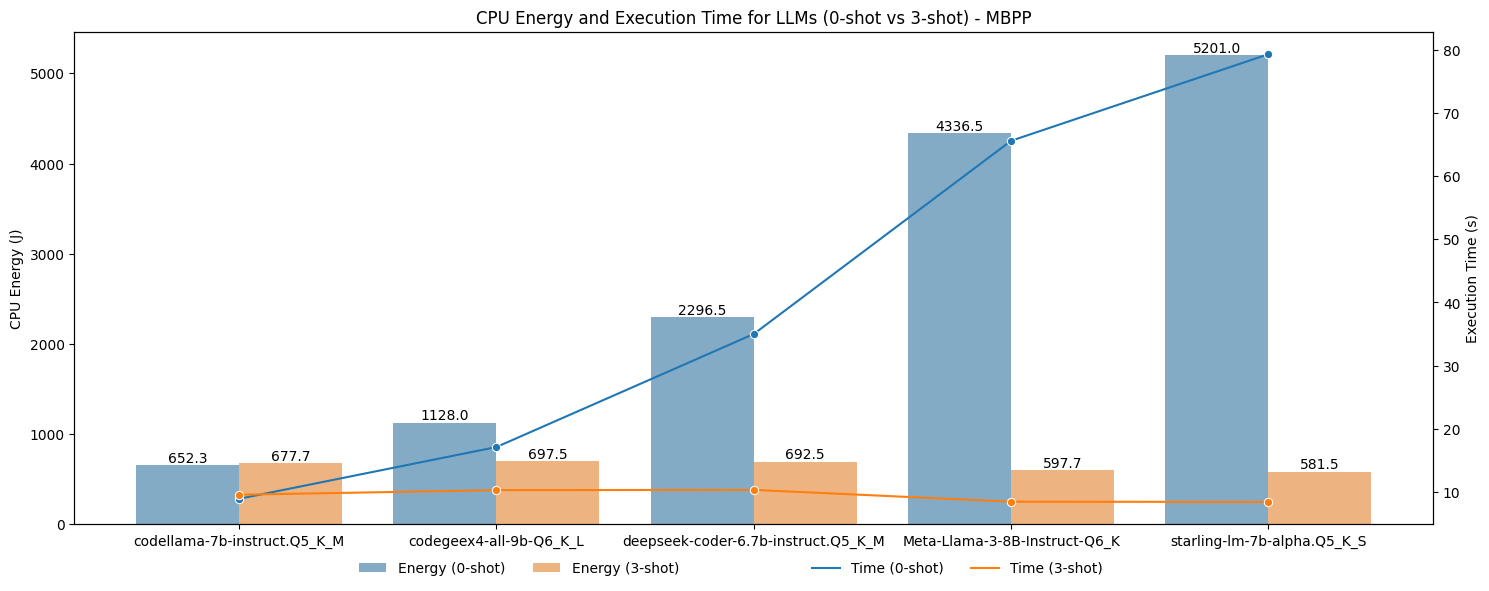

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que df_combined_mbpp já esteja declarado conforme mostrado

# Filtrando os dados para 0-shot e 3-shot
df_0_shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '0-shot'][['LLM', 'CPU Energy (J)', 'Execution time (s)']]
df_3_shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '3-shot'][['LLM', 'CPU Energy (J)', 'Execution time (s)']]

# Renomeando as colunas para facilitar a plotagem
df_0_shot.rename(columns={'CPU Energy (J)': 'Energy (0-shot)', 'Execution time (s)': 'Execution time (0-shot)'}, inplace=True)
df_3_shot.rename(columns={'CPU Energy (J)': 'Energy (3-shot)', 'Execution time (s)': 'Execution time (3-shot)'}, inplace=True)

# Fazendo um merge dos dois dataframes com base na coluna 'LLM'
df_merged = pd.merge(df_0_shot, df_3_shot, on='LLM')

# Calculando a média da energia para cada LLM
df_merged['Total Energy'] = df_merged[['Energy (0-shot)', 'Energy (3-shot)']].mean(axis=1)

# Ordenando os dados com base na energia total
df_sorted = df_merged.sort_values(by='Total Energy')

# Definindo o tamanho da figura
plt.figure(figsize=(15, 6))

# Criando um barplot para CPU Energy
barplot = sns.barplot(data=df_sorted.melt(id_vars='LLM', value_vars=['Energy (0-shot)', 'Energy (3-shot)'], var_name='Shot', value_name='CPU Energy'), 
                      x='LLM', y='CPU Energy', hue='Shot', alpha=0.6)

# Adicionando títulos e rótulos
plt.title('CPU Energy and Execution Time for LLMs (0-shot vs 3-shot) - MBPP')
plt.xlabel('')
plt.ylabel('CPU Energy (J)')

# Adicionando rótulos às barras
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.1f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', 
                     fontsize=10, color='black', 
                     rotation=0)

# Criando um segundo eixo y para Execution time
ax2 = barplot.twinx()

# Plotando o Execution time
sns.lineplot(data=df_sorted.melt(id_vars='LLM', value_vars=['Execution time (0-shot)', 'Execution time (3-shot)']),
             x='LLM', y='value', hue='variable', ax=ax2, marker='o', color='black')

# Adicionando rótulos e título para o eixo y da direita
ax2.set_ylabel('Execution Time (s)')

# Configurando a legenda para o eixo das barras (ax1)
handles1, labels1 = barplot.get_legend_handles_labels()
barplot.legend(handles1, labels1, title='', loc='upper left', bbox_to_anchor=(0.2, -0.05), ncol=2, frameon=False)

# Configurando a legenda para o eixo das linhas (ax2)
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2, ['Time (0-shot)', 'Time (3-shot)'], title='', loc='upper center', bbox_to_anchor=(0.65, -0.05), ncol=2, frameon=False)

# Exibindo o gráfico
plt.tight_layout()
plt.show()


#### Pass@k vs BLEU

In [35]:
df_combined_mbpp

,LLM,Execution time (s),CPU Energy (J),MBPP (unsanitized) pass@1,MBPP+ (unsanitized) pass@1,MBPP (sanitized) pass@1,MBPP+ (sanitized) pass@1,MBPP (unsanitized) pass@10,MBPP+ (unsanitized) pass@10,MBPP (sanitized) pass@10,MBPP+ (sanitized) pass@10,GoogleBLEU (unsanitized),CodeBLEU (unsanitized),SacreBLEU (unsanitized),GoogleBLEU (sanitized),CodeBLEU (sanitized),SacreBLEU (sanitized),Shot
0,Meta-Llama-3-8B-Instruct-Q6_K,65.649756,4336.466439,0.654000,0.542000,0.686000,0.569000,0.835000,0.725000,0.837000,0.728000,0.069140,0.315794,0.062450,0.168783,0.244199,0.185539,0-shot
1,codegeex4-all-9b-Q6_K_L,17.069976,1127.984104,0.000000,0.000000,0.274000,0.212000,0.000000,0.000000,0.595000,0.489000,0.192322,0.309949,0.179499,0.176930,0.189083,0.176504,0-shot
2,codellama-7b-instruct.Q5_K_M,8.857723,652.304952,0.357000,0.293000,0.393000,0.317000,0.733000,0.611000,0.751000,0.624000,0.251664,0.282798,0.257672,0.209960,0.207058,0.207026,0-shot
3,deepseek-coder-6.7b-instruct.Q5_K_M,35.003395,2296.474371,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.101692,0.327037,0.091833,0.255243,0.260233,0.273627,0-shot
4,starling-lm-7b-alpha.Q5_K_S,79.387905,5201.048618,0.074000,0.060000,0.428000,0.354000,0.444000,0.370000,0.820000,0.698000,0.043459,0.325714,0.037512,0.191784,0.232059,0.223515,0-shot
5,Meta-Llama-3-8B-Instruct-Q6_K,8.404732,597.672158,0.189239,0.163618,0.604247,0.511848,0.677383,0.587888,0.871325,0.764819,0.187449,0.325431,0.182965,0.318473,0.308447,0.336522,3-shot
6,codegeex4-all-9b-Q6_K_L,10.235238,697.542414,0.003005,0.002600,0.279231,0.216749,0.010665,0.009264,0.599328,0.493328,0.249802,0.301452,0.247107,0.261156,0.263478,0.286512,3-shot
7,codellama-7b-instruct.Q5_K_M,9.508065,677.677904,0.096343,0.078567,0.437939,0.362282,0.459062,0.383675,0.820655,0.699156,0.072520,0.293982,0.064890,0.226153,0.252981,0.248980,3-shot
8,deepseek-coder-6.7b-instruct.Q5_K_M,10.275680,692.523864,0.000000,0.000000,0.274000,0.212000,0.000000,0.000000,0.595000,0.489000,0.232791,0.303344,0.226073,0.239567,0.244764,0.259863,3-shot
9,starling-lm-7b-alpha.Q5_K_S,8.364644,581.524990,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.156937,0.324664,0.149289,0.304495,0.297625,0.322965,3-shot


#### Pass@1 and Pass@10

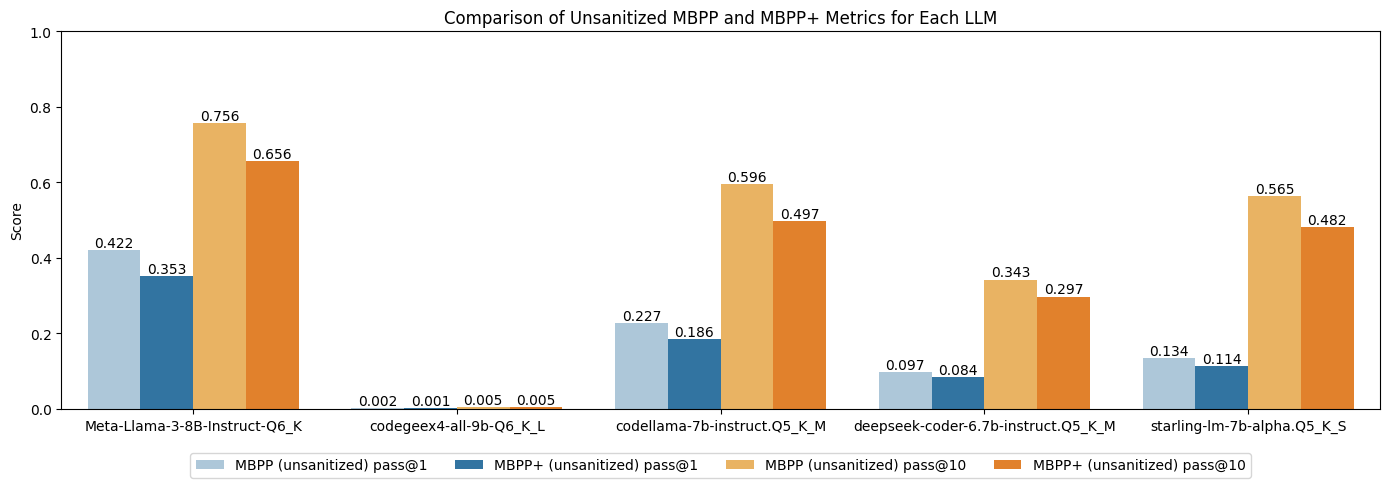

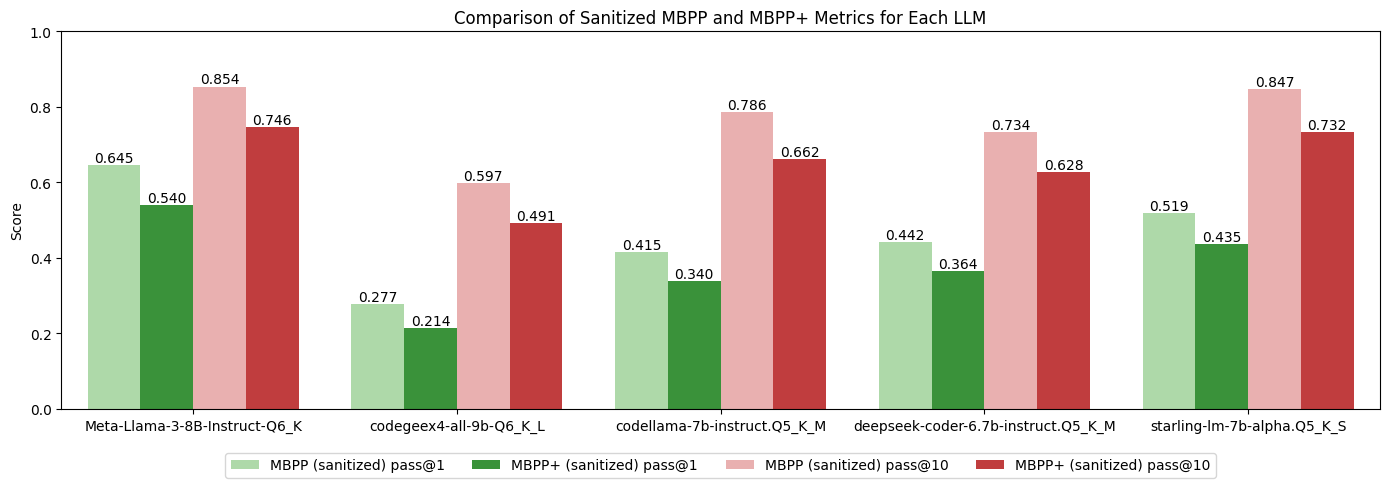

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_combined_mbpp is already defined

# Melt the DataFrame for unsanitized metrics
df_melted_unsanitized = df_combined_mbpp.melt(
    id_vars=['LLM', 'Shot'], 
    value_vars=[
        'MBPP (unsanitized) pass@1',
        'MBPP+ (unsanitized) pass@1',
        'MBPP (unsanitized) pass@10',
        'MBPP+ (unsanitized) pass@10'
    ], 
    var_name='Metric', 
    value_name='Score'
)

# Melt the DataFrame for sanitized metrics
df_melted_sanitized = df_combined_mbpp.melt(
    id_vars=['LLM', 'Shot'], 
    value_vars=[
        'MBPP (sanitized) pass@1',
        'MBPP+ (sanitized) pass@1',
        'MBPP (sanitized) pass@10',
        'MBPP+ (sanitized) pass@10'
    ], 
    var_name='Metric', 
    value_name='Score'
)

# Define custom palette for unsanitized metrics
palette_unsanitized = {
    'MBPP (unsanitized) pass@1': '#a6c8e0',   # Light blue
    'MBPP+ (unsanitized) pass@1': '#1f77b4',  # Dark blue
    'MBPP (unsanitized) pass@10': '#ffb84d',   # Light orange
    'MBPP+ (unsanitized) pass@10': '#ff7f0e'   # Dark orange
}

# Define custom palette for sanitized metrics
palette_sanitized = {
    'MBPP (sanitized) pass@1': '#a8e1a1',   # Light green
    'MBPP+ (sanitized) pass@1': '#2ca02c',  # Dark green
    'MBPP (sanitized) pass@10': '#f2a6a6',  # Light red
    'MBPP+ (sanitized) pass@10': '#d62728'   # Dark red
}

# Plotting the graph for unsanitized metrics
plt.figure(figsize=(14, 5))
ax = sns.barplot(data=df_melted_unsanitized, x='LLM', y='Score', hue='Metric', ci=None, palette=palette_unsanitized, dodge=True)

plt.title("Comparison of Unsanitized MBPP and MBPP+ Metrics for Each LLM")
plt.xlabel("")
plt.ylabel("Score")
plt.ylim(0, 1)

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

# Place the legend below the plot and centered
plt.legend(title=None, bbox_to_anchor=(0.5, -0.15), loc='center', ncol=4)

plt.grid(False)
plt.tight_layout()
plt.show()

# Plotting the graph for sanitized metrics
plt.figure(figsize=(14, 5))
ax = sns.barplot(data=df_melted_sanitized, x='LLM', y='Score', hue='Metric', ci=None, palette=palette_sanitized, dodge=True)

plt.title("Comparison of Sanitized MBPP and MBPP+ Metrics for Each LLM")
plt.xlabel("")
plt.ylabel("Score")
plt.ylim(0, 1)

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

# Place the legend below the plot and centered
plt.legend(title=None, bbox_to_anchor=(0.5, -0.15), loc='center', ncol=4)

plt.grid(False)
plt.tight_layout()
plt.show()



#### BLEU

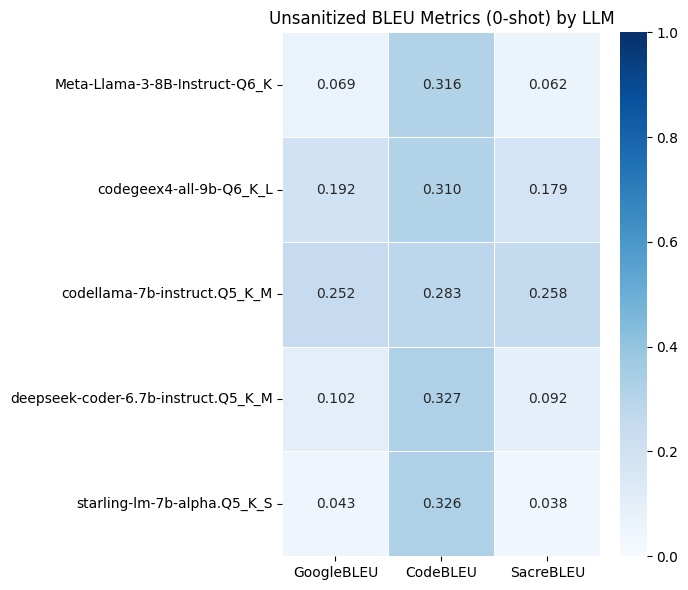

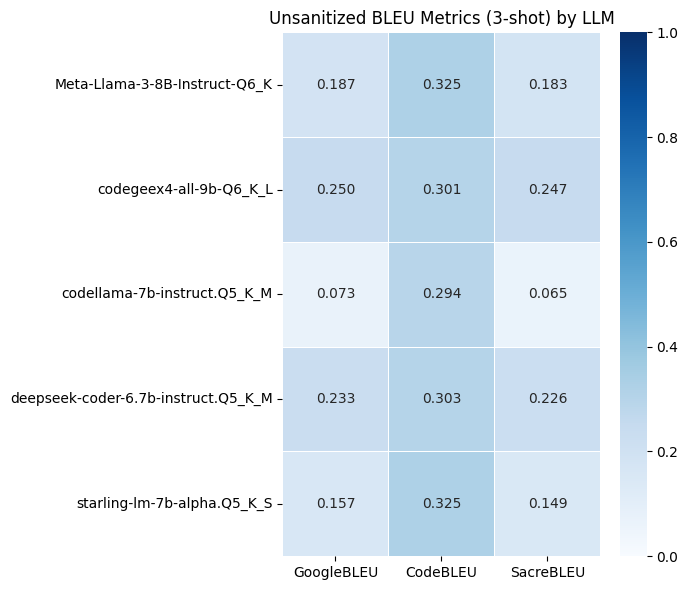

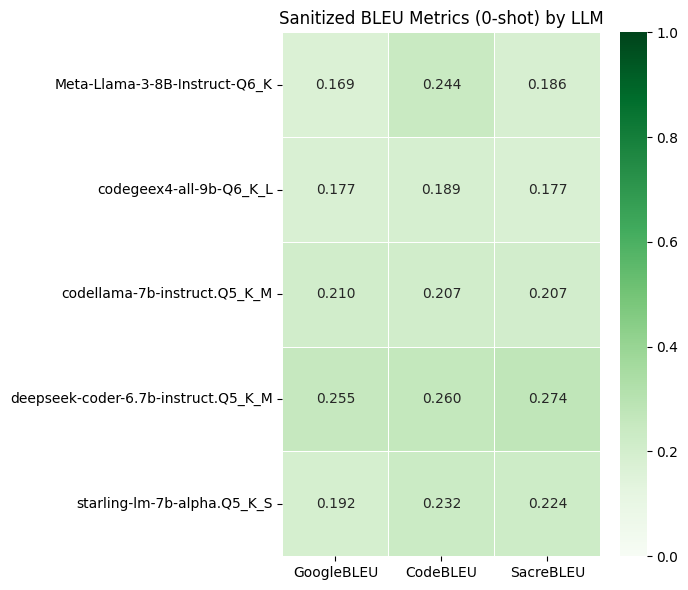

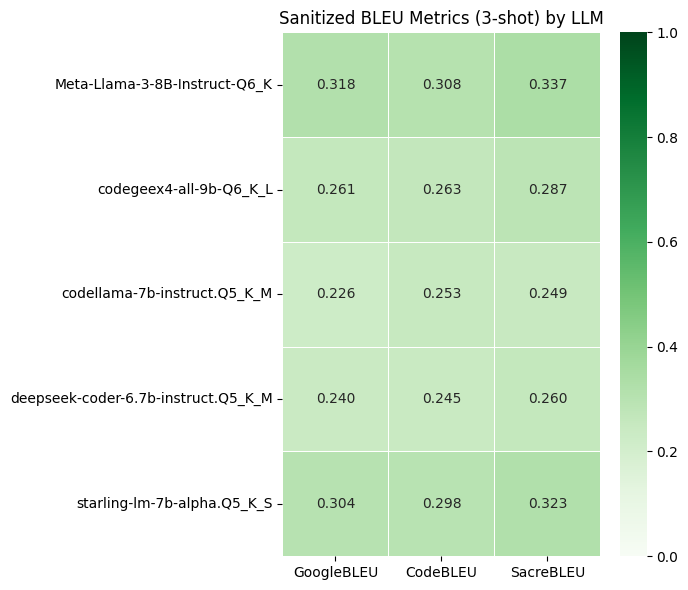

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_combined_mbpp is already defined

# Filter DataFrames for unsanitized BLEU metrics
df_bleu_unsanitized_0shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '0-shot'][['LLM', 'GoogleBLEU (unsanitized)', 'CodeBLEU (unsanitized)', 'SacreBLEU (unsanitized)']]
df_bleu_unsanitized_0shot.columns = ['LLM', 'GoogleBLEU', 'CodeBLEU', 'SacreBLEU']  # Rename columns
df_bleu_unsanitized_0shot = df_bleu_unsanitized_0shot.set_index('LLM')

df_bleu_unsanitized_3shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '3-shot'][['LLM', 'GoogleBLEU (unsanitized)', 'CodeBLEU (unsanitized)', 'SacreBLEU (unsanitized)']]
df_bleu_unsanitized_3shot.columns = ['LLM', 'GoogleBLEU', 'CodeBLEU', 'SacreBLEU']  # Rename columns
df_bleu_unsanitized_3shot = df_bleu_unsanitized_3shot.set_index('LLM')

# Filter DataFrames for sanitized BLEU metrics
df_bleu_sanitized_0shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '0-shot'][['LLM', 'GoogleBLEU (sanitized)', 'CodeBLEU (sanitized)', 'SacreBLEU (sanitized)']]
df_bleu_sanitized_0shot.columns = ['LLM', 'GoogleBLEU', 'CodeBLEU', 'SacreBLEU']  # Rename columns
df_bleu_sanitized_0shot = df_bleu_sanitized_0shot.set_index('LLM')

df_bleu_sanitized_3shot = df_combined_mbpp[df_combined_mbpp['Shot'] == '3-shot'][['LLM', 'GoogleBLEU (sanitized)', 'CodeBLEU (sanitized)', 'SacreBLEU (sanitized)']]
df_bleu_sanitized_3shot.columns = ['LLM', 'GoogleBLEU', 'CodeBLEU', 'SacreBLEU']  # Rename columns
df_bleu_sanitized_3shot = df_bleu_sanitized_3shot.set_index('LLM')

width = 7
height = 6

# Create heatmap for unsanitized BLEU metrics - 0-shot
plt.figure(figsize=(width, height))
sns.heatmap(df_bleu_unsanitized_0shot, annot=True, cmap='Blues', fmt='.3f', linewidths=0.5, vmin=0, vmax=1)
plt.title('Unsanitized BLEU Metrics (0-shot) by LLM')
plt.xlabel('')
plt.ylabel('')
plt.ylim(len(df_bleu_unsanitized_0shot), 0)  # Reverse y-axis for better visual
plt.tight_layout()
plt.show()

# Create heatmap for unsanitized BLEU metrics - 3-shot
plt.figure(figsize=(width, height))
sns.heatmap(df_bleu_unsanitized_3shot, annot=True, cmap='Blues', fmt='.3f', linewidths=0.5, vmin=0, vmax=1)
plt.title('Unsanitized BLEU Metrics (3-shot) by LLM')
plt.xlabel('')
plt.ylabel('')
plt.ylim(len(df_bleu_unsanitized_3shot), 0)  # Reverse y-axis for better visual
plt.tight_layout()
plt.show()

# Create heatmap for sanitized BLEU metrics - 0-shot
plt.figure(figsize=(width, height))
sns.heatmap(df_bleu_sanitized_0shot, annot=True, cmap='Greens', fmt='.3f', linewidths=0.5, vmin=0, vmax=1)
plt.title('Sanitized BLEU Metrics (0-shot) by LLM')
plt.xlabel('')
plt.ylabel('')
plt.ylim(len(df_bleu_sanitized_0shot), 0)  # Reverse y-axis for better visual
plt.tight_layout()
plt.show()

# Create heatmap for sanitized BLEU metrics - 3-shot
plt.figure(figsize=(width, height))
sns.heatmap(df_bleu_sanitized_3shot, annot=True, cmap='Greens', fmt='.3f', linewidths=0.5, vmin=0, vmax=1)
plt.title('Sanitized BLEU Metrics (3-shot) by LLM')
plt.xlabel('')
plt.ylabel('')
plt.ylim(len(df_bleu_sanitized_3shot), 0)  # Reverse y-axis for better visual
plt.tight_layout()
plt.show()


### LLM Ranking

In [38]:
df_combined_mbpp

,LLM,Execution time (s),CPU Energy (J),MBPP (unsanitized) pass@1,MBPP+ (unsanitized) pass@1,MBPP (sanitized) pass@1,MBPP+ (sanitized) pass@1,MBPP (unsanitized) pass@10,MBPP+ (unsanitized) pass@10,MBPP (sanitized) pass@10,MBPP+ (sanitized) pass@10,GoogleBLEU (unsanitized),CodeBLEU (unsanitized),SacreBLEU (unsanitized),GoogleBLEU (sanitized),CodeBLEU (sanitized),SacreBLEU (sanitized),Shot
0,Meta-Llama-3-8B-Instruct-Q6_K,65.649756,4336.466439,0.654000,0.542000,0.686000,0.569000,0.835000,0.725000,0.837000,0.728000,0.069140,0.315794,0.062450,0.168783,0.244199,0.185539,0-shot
1,codegeex4-all-9b-Q6_K_L,17.069976,1127.984104,0.000000,0.000000,0.274000,0.212000,0.000000,0.000000,0.595000,0.489000,0.192322,0.309949,0.179499,0.176930,0.189083,0.176504,0-shot
2,codellama-7b-instruct.Q5_K_M,8.857723,652.304952,0.357000,0.293000,0.393000,0.317000,0.733000,0.611000,0.751000,0.624000,0.251664,0.282798,0.257672,0.209960,0.207058,0.207026,0-shot
3,deepseek-coder-6.7b-instruct.Q5_K_M,35.003395,2296.474371,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.101692,0.327037,0.091833,0.255243,0.260233,0.273627,0-shot
4,starling-lm-7b-alpha.Q5_K_S,79.387905,5201.048618,0.074000,0.060000,0.428000,0.354000,0.444000,0.370000,0.820000,0.698000,0.043459,0.325714,0.037512,0.191784,0.232059,0.223515,0-shot
5,Meta-Llama-3-8B-Instruct-Q6_K,8.404732,597.672158,0.189239,0.163618,0.604247,0.511848,0.677383,0.587888,0.871325,0.764819,0.187449,0.325431,0.182965,0.318473,0.308447,0.336522,3-shot
6,codegeex4-all-9b-Q6_K_L,10.235238,697.542414,0.003005,0.002600,0.279231,0.216749,0.010665,0.009264,0.599328,0.493328,0.249802,0.301452,0.247107,0.261156,0.263478,0.286512,3-shot
7,codellama-7b-instruct.Q5_K_M,9.508065,677.677904,0.096343,0.078567,0.437939,0.362282,0.459062,0.383675,0.820655,0.699156,0.072520,0.293982,0.064890,0.226153,0.252981,0.248980,3-shot
8,deepseek-coder-6.7b-instruct.Q5_K_M,10.275680,692.523864,0.000000,0.000000,0.274000,0.212000,0.000000,0.000000,0.595000,0.489000,0.232791,0.303344,0.226073,0.239567,0.244764,0.259863,3-shot
9,starling-lm-7b-alpha.Q5_K_S,8.364644,581.524990,0.193000,0.167000,0.610000,0.517000,0.685000,0.595000,0.873000,0.767000,0.156937,0.324664,0.149289,0.304495,0.297625,0.322965,3-shot


In [51]:
# Split the DataFrame into 0-shot and 3-shot DataFrames
df_0_shot = df_combined_mbpp[df_combined_mbpp["Shot"] == "0-shot"].copy()
df_3_shot = df_combined_mbpp[df_combined_mbpp["Shot"] == "3-shot"].copy()

# Rename columns for clarity
df_0_shot.rename(columns={
    "Execution time (s)": "Execution time 0-shot (s)",
    "CPU Energy (J)": "CPU Energy 0-shot (J)"
}, inplace=True)

df_3_shot.rename(columns={
    "Execution time (s)": "Execution time 3-shot (s)",
    "CPU Energy (J)": "CPU Energy 3-shot (J)"
}, inplace=True)

# Merge the DataFrames on LLM
merged_df = pd.merge(df_0_shot, df_3_shot, on="LLM", how="inner")

# Calculate gains
merged_df["Energy Gain (J)"] = merged_df["CPU Energy 3-shot (J)"] - merged_df["CPU Energy 0-shot (J)"]
merged_df["Time Gain (s)"] = merged_df["Execution time 3-shot (s)"] - merged_df["Execution time 0-shot (s)"]

# Calculate the mean for each LLM
df_mean_metrics = merged_df.groupby('LLM').agg({
    'Energy Gain (J)': 'mean',
    'Time Gain (s)': 'mean',
    'CPU Energy 0-shot (J)': 'mean',
    'Execution time 0-shot (s)': 'mean'
}).reset_index()

# Normalize Energy and Time gains starting from 1
df_mean_metrics['Energy'] = ((df_mean_metrics['Energy Gain (J)'] - df_mean_metrics['Energy Gain (J)'].min()) /
                             (df_mean_metrics['Energy Gain (J)'].max() - df_mean_metrics['Energy Gain (J)'].min())) + 1

df_mean_metrics['Time'] = ((df_mean_metrics['Time Gain (s)'] - df_mean_metrics['Time Gain (s)'].min()) /
                           (df_mean_metrics['Time Gain (s)'].max() - df_mean_metrics['Time Gain (s)'].min())) + 1

# Add differences and percentage differences
df_mean_metrics['Energy Difference (J)'] = df_mean_metrics['Energy Gain (J)']
df_mean_metrics['Energy Difference (%)'] = (df_mean_metrics['Energy Difference (J)'] / df_mean_metrics['CPU Energy 0-shot (J)']) * 100
df_mean_metrics['Time Difference (s)'] = df_mean_metrics['Time Gain (s)']
df_mean_metrics['Time Difference (%)'] = (df_mean_metrics['Time Difference (s)'] / df_mean_metrics['Execution time 0-shot (s)']) * 100

# Rank the models based on Energy differences, converting to integer
df_mean_metrics['Rank'] = df_mean_metrics['Energy Difference (J)'].rank(ascending=True, method='min').astype(int)

# Sort the DataFrame by 'Energy Difference (J)' in descending order
df_ranked = df_mean_metrics.sort_values(by='Energy Difference (J)')

# Reorganize columns for better visualization
df_ranked = df_ranked[['Rank', 'LLM', 'Energy', 'Time', 
                       'Energy Difference (J)', 'Energy Difference (%)', 
                       'Time Difference (s)', 'Time Difference (%)']]

df_ranked.style.hide_index()

/tmp/ipykernel_10671/3776293135.py:55: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  df_ranked.style.hide_index()


Rank,LLM,Energy,Time,Energy Difference (J),Energy Difference (%),Time Difference (s),Time Difference (%)
1,starling-lm-7b-alpha.Q5_K_S,1.000000,1.000000,-4619.523628,-88.819082,-71.023260,-89.463578
2,Meta-Llama-3-8B-Instruct-Q6_K,1.189612,1.192236,-3738.794281,-86.217531,-57.245025,-87.197619
3,deepseek-coder-6.7b-instruct.Q5_K_M,1.649223,1.645922,-1603.950506,-69.844041,-24.727715,-70.643762
4,codegeex4-all-9b-Q6_K_L,1.901868,1.895567,-430.441690,-38.160262,-6.834738,-40.039530
5,codellama-7b-instruct.Q5_K_M,2.000000,2.000000,25.372951,3.889738,0.650342,7.342095
